In [1]:
# !pip install numpy==1.23.5
import matplotlib.pyplot as plt
import os
import sys

args = ''
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print('Jax version:        ', jax.__version__)
print('Python version:     ', sys.version)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

Selected GPU 


2024-05-27 22:09:20.764757: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Jax version:         0.4.16
Python version:      3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
Jax default backend: cpu
Jax devices:         [CpuDevice(id=0)]


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('/home/davcic/CP_Testing')
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic


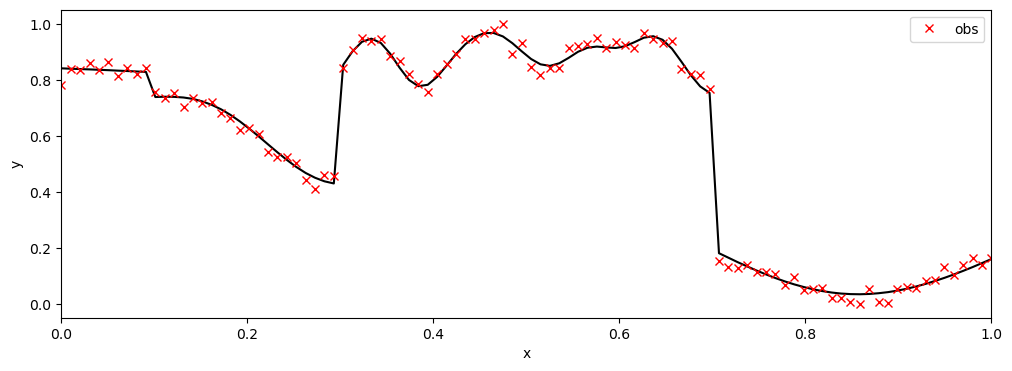

In [4]:
key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_,
                    num = x0)

min_add_y = jnp.abs(jnp.minimum(0, jnp.min(y)))
max_y = jnp.max(y + min_add_y)
# min_y = jnp.min(y)
new_y = (y+ min_add_y)/max_y 

# min_add_f = jnp.abs(jnp.minimum(0, jnp.min(f_true)))
# max_f = jnp.max(f_true + jnp.abs(jnp.minimum(0, jnp.min(f_true))))
# min_f = jnp.min(f_true)
new_f_true = (f_true + min_add_y)/max_y 
# max_y = jnp.max(jnp.abs(y))
# new_y = (y)/max_y 

# max_f = jnp.max(jnp.abs(f_true))
# new_f_true = (f_true)/max_y 


plt.figure(figsize=(12, 4))
plt.plot(x, new_f_true, 'k', label=r'')
plt.plot(x, new_y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [6]:
from scipy import linalg
def MVN_log_prob(mu, cov, y):
    L = jnp.linalg.cholesky(cov)
    norm = -len(mu)/2 * jnp.log(2 * jnp.pi) - 1/2 * 2 * jnp.sum(jnp.log(jnp.diag(L))) 
    # print(- 1/2 *2 * jnp.sum(jnp.log(jnp.diag(L))))
    # print(-len(mu)/2 * jnp.log(2 * jnp.pi))
    # print(f'Normalizing constant of MVN: {norm}')
    prob = -1/2 * (y - mu).T@linalg.inv(cov)@(y - mu)
    # (jnp.linalg.inv(L)@jnp.linalg.inv(L.T))
    # print(f'Log Probability factor in MVN: {prob}')
    return norm + prob
def UN_log_prob(mu, sigma, y):
    norm = jnp.zeros(len(y)) -1/2 * jnp.log(2 * jnp.pi) - jnp.log(sigma)
    # print(len(y) * -jnp.log(sigma))
    # print(len(y) * (-1/2) * jnp.log(2 * jnp.pi))
    print(f'Normalizing constant of Univariate: {jnp.sum(norm)}')
    prob = -1/2 * ((y - mu)**2) / sigma ** 2
    print(f'Log Probability factor in Univariate: {jnp.sum(prob)}')
    return jnp.sum(norm + prob)

In [103]:
n = 100
print(f'Log Probability of f_true in MVN: {MVN_log_prob(jnp.zeros(n), K, new_f_true)}')
print(f'Log Probability of y in Univariate: {UN_log_prob(new_f_true, obs_noise_, new_y)}')


Normalizing constant of MVN: 396.5000148129348
Log Probability factor in MVN: -3.131867186812265
Log Probability of f_true in MVN: 393.36814762612255
Normalizing constant of Univariate: 69.04993792294275
Log Probability factor in Univariate: -1.156605983748123
Log Probability of y in Univariate: 67.89333193919464


In [107]:
key = jrnd.PRNGKey(12345)
lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_alt = jnp.dot(L, z) + jnp.ones_like(z)

# max_y = jnp.max(jnp.abs(y))
# # min_y = jnp.min(y)
# new_y = y/max_y
max_f = jnp.max(jnp.abs(f_alt))
# min_f = jnp.min(f_true)
new_f_alt = f_alt/max_f

print(f'Log Probability of f_true in MVN: {MVN_log_prob(jnp.zeros(n), K + 0.0*jnp.eye(n), new_f_true)}')
print(f'Log Probability of y in Univariate: {UN_log_prob(new_f_alt, obs_noise_, new_y)}')

Normalizing constant of MVN: 402.35210344361286
Log Probability factor in MVN: -3.978455817797745
Log Probability of f_true in MVN: 398.3736476258151
Normalizing constant of Univariate: 69.04993792294275
Log Probability factor in Univariate: -5.600735215090044
Log Probability of y in Univariate: 63.44920270785272


In [7]:
key = jrnd.PRNGKey(12345)
lengthscale_ = jnp.array([1])
output_scale_ = jnp.array([1])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)

sigma = 10**jnp.linspace(-6, -1, 6)
n_all = 10**jnp.linspace(2, 2, 1, dtype = int)
for n in n_all:
    lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
    output_scale_ = jnp.array([3, 2, 1, 5])
    obs_noise_ = 0.2
    x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
    x0 = jnp.array([0.3, 0.1, 0.7])
    # x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
    #x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
    base_kernel = jk.RBF()
    kernel = Discontinuous_multiple_params(base_kernel, x0)
    K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                            variance=output_scale_,
                                            num=x0),
                                x=x, y=x)+ 1e-6*jnp.eye(n)
    
    L = jnp.linalg.cholesky(K+ 1e-6*jnp.eye(n))
    z = jrnd.normal(key, shape=(n,))

    f_true = jnp.dot(L, z) + jnp.ones_like(z)
    max_f = jnp.max(jnp.abs(f_true))
    new_f_true = f_true/max_f


    lengthscale_ = jnp.array([0.2])
    output_scale_ = jnp.array([0.5])
    obs_noise_ = 0.2
    x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
    x0 = jnp.array([])
    # x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
    #x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
    base_kernel = jk.RBF()
    kernel = Discontinuous_multiple_params(base_kernel, x0)
    K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                            variance=output_scale_,
                                            num=x0),
                                x=x, y=x)
    
    for sig in sigma:
        # print(f'Log Probability of f_true in MVN {sig}: {MVN_log_prob(jnp.zeros(n), K + sig*jnp.eye(n), new_f_true)}')
        print(f'Log Probability Magnitude of f_true in MVN 0 CP {n} {sig}: {jnp.log10(jnp.abs(MVN_log_prob(jnp.zeros(n), K + sig*jnp.eye(n), new_f_true)))}')

    lengthscale_ = jnp.array([1, 0.3, 0.3, 0.7, 0.04, 0.09, 2, 0.8, 0.1, 1.4])
    output_scale_ = jnp.array([1, 5, 2, 1.4, 0.5, 0.4, 3, 2.4, 3, 0.3, 3.5])
    obs_noise_ = 0.2
    x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
    x0 = jnp.array([0.03, 0.1, 0.14, 0.2, 0.3, 0.31, 0.5, 0.81, 0.67, 0.9])
    # x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
    #x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
    base_kernel = jk.RBF()
    kernel = Discontinuous_multiple_params(base_kernel, x0)
    K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                            variance=output_scale_,
                                            num=x0),
                                x=x, y=x)
    
    for sig in sigma:
        # print(f'Log Probability of f_true in MVN {sig}: {MVN_log_prob(jnp.zeros(n), K + sig*jnp.eye(n), new_f_true)}')
        print(f'Log Probability Magnitude of f_true in MVN 10 CP {n} {sig}: {jnp.log10(jnp.abs(MVN_log_prob(jnp.zeros(n), K + sig*jnp.eye(n), new_f_true)))}')

# L = jnp.linalg.cholesky(K+ 1e-6*jnp.eye(n))
# z = jrnd.normal(key, shape=(n,))

# f_alt = jnp.dot(L, z) + jnp.ones_like(z)

# max_f = jnp.max(jnp.abs(f_alt))
# new_f_alt = f_alt/max_f
# print(f'Log Probability of y in Univariate: {UN_log_prob(new_f_alt, obs_noise_, new_y)}')

Log Probability Magnitude of f_true in MVN 0 CP 100 1e-06: 6.008803112538644
Log Probability Magnitude of f_true in MVN 0 CP 100 1e-05: 5.029263234695512
Log Probability Magnitude of f_true in MVN 0 CP 100 0.0001: 4.082080656100776
Log Probability Magnitude of f_true in MVN 0 CP 100 0.001: 3.1014854310495834
Log Probability Magnitude of f_true in MVN 0 CP 100 0.010000000000000005: 1.8005589186058129
Log Probability Magnitude of f_true in MVN 0 CP 100 0.1: 1.0291377045358132
Log Probability Magnitude of f_true in MVN 10 CP 100 1e-06: 5.278356868056429
Log Probability Magnitude of f_true in MVN 10 CP 100 1e-05: 4.348602004926351
Log Probability Magnitude of f_true in MVN 10 CP 100 0.0001: 3.3756879508645063
Log Probability Magnitude of f_true in MVN 10 CP 100 0.001: 2.0494597844942444
Log Probability Magnitude of f_true in MVN 10 CP 100 0.010000000000000005: 1.6983620654352654
Log Probability Magnitude of f_true in MVN 10 CP 100 0.1: 1.1757676713000695


### Maximum value for Univariate

In [146]:
n = 1
max_dist = 2
max_obs = 0.1
data = jnp.zeros(n)
y = jnp.zeros(n) + 1 
print(f'Log Probability of y in Univariate: {UN_log_prob(data, max_obs, y)}')
print(f'Avg Max val is {-1/2 * n/(max_obs)**2}')

Normalizing constant of Univariate: 1.3836465597893728
Log Probability factor in Univariate: -49.99999999999999
Log Probability of y in Univariate: -48.61635344021062
Avg Max val is -49.99999999999999


In [152]:
jnp.std(new_y)

Array(0.35292369, dtype=float64)